In [1]:
# Add needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# VIF for multi-collinearity detection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models and modeling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

# Models and modeling tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Change inline plots default size
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
# Read in the rawData
rawData = pd.read_csv('term-deposit-marketing-2020.csv')

# Separate data in independent (features) and dependent (target) datasets
features = rawData.copy()
target = features.pop('y')

# Replace target 'yes'/'no' with 1/0
target.replace({'yes':1,'no':0}, inplace=True)

# Split data initially
x_initial, x_test, y_initial, y_test = train_test_split(features, target, test_size=0.10, random_state=10)
x_train, x_valid, y_train, y_valid = train_test_split(x_initial, y_initial, test_size=0.10, random_state=20)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [3]:
# Replace binary columns 1/0
for col in ['default', 'housing', 'loan']:
    x_train[col].replace({'yes':1,'no':0}, inplace=True)
    x_valid[col].replace({'yes':1,'no':0}, inplace=True)
    x_test[col].replace({'yes':1,'no':0}, inplace=True)

# Encode small categorical columns
cols = ['marital', 'education', 'contact']

enc = OneHotEncoder(sparse=False, dtype=int)
encodedTrain = enc.fit_transform(x_train[cols])
encodedValid = enc.transform(x_valid[cols])
encodedTest = enc.transform(x_test[cols])

# There has got to be a better way to do this...
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    for i in range(len(cols)):
        encNames[index] = encNames[index].replace('x' + str(i), cols[i])

encDFTrain = pd.DataFrame(encodedTrain)
encDFTrain.columns = encNames
encDFValid = pd.DataFrame(encodedValid)
encDFValid.columns = encNames
encDFTest = pd.DataFrame(encodedTest)
encDFTest.columns = encNames

x_train = x_train.drop(columns=cols)
x_train = pd.concat([x_train, encDFTrain], axis=1)
x_valid = x_valid.drop(columns=cols)
x_valid = pd.concat([x_valid, encDFValid], axis=1)
x_test = x_test.drop(columns=cols)
x_test = pd.concat([x_test, encDFTest], axis=1)

# Encode large categorical columns
cols = ['month', 'job']

enc = OneHotEncoder(sparse=False, dtype=int)
encodedTrain = enc.fit_transform(x_train[cols])
encodedValid = enc.transform(x_valid[cols])
encodedTest = enc.transform(x_test[cols])


# There has got to be a better way to do this...
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    for i in range(len(cols)):
        encNames[index] = encNames[index].replace('x' + str(i), cols[i])

encDFTrain = pd.DataFrame(encodedTrain)
encDFTrain.columns = encNames
encDFValid = pd.DataFrame(encodedValid)
encDFValid.columns = encNames
encDFTest = pd.DataFrame(encodedTest)
encDFTest.columns = encNames

x_train = x_train.drop(columns=cols)
x_train = pd.concat([x_train, encDFTrain], axis=1)
x_valid = x_valid.drop(columns=cols)
x_valid = pd.concat([x_valid, encDFValid], axis=1)
x_test = x_test.drop(columns=cols)
x_test = pd.concat([x_test, encDFTest], axis=1)

# Oversample the minority set in the training data
oversample = SMOTE()
ovFeatures, ovTarget = oversample.fit_resample(x_train, y_train)

# Remove duration (this is not a reasonable thing to have in the model as it should tell success/failure well?)
#features = features.drop(columns=['duration'])

In [103]:
#### Add modified columns

# Unskewed cols
cols = ['balance', 'duration']
for item in cols:
    shift = x_train[item].min()
    name = 'log-' + item
    
    # Shift minimum value to 1 then log them
    x_train[name] = x_train[item] - shift + 1
    x_train[name] = np.log(x_train[name])
    x_valid[name] = x_valid[item] - shift + 1
    x_valid[name] = np.log(x_valid[name])
    x_test[name] = x_test[item] - shift + 1
    x_test[name] = np.log(x_test[name])
    
cols = ['campaign', 'age']
for item in cols:
    #mean = x_train[item].mean()
    #std = x_train[item].std()
    name = 'cube-' + item

    #x_train[name] = (x_train[item] - mean)/std
    #x_valid[name] = (x_valid[item] - mean)/std
    #x_test[name] = (x_test[item] - mean)/std
    
    x_train[name] = np.cbrt(x_train[item])
    x_valid[name] = np.cbrt(x_valid[item])
    x_test[name] = np.cbrt(x_test[item])
    
# Some binning
for dataset in [x_train, x_valid, x_test]:
    # seasons
    dataset['summer'] = dataset['month_jun'] + dataset['month_jul'] + dataset['month_aug']
    dataset['fall'] = dataset['month_oct'] + dataset['month_nov'] # No entries for sept in dataset
    dataset['winter'] = dataset['month_dec'] + dataset['month_jan'] + dataset['month_feb']
    dataset['spring'] = dataset['month_mar'] + dataset['month_apr'] + dataset['month_may']
    
    # bin age
    dataset['<25'] = (dataset['age'] < 25).replace({True:1,False:0})
    dataset['25-32'] = ((dataset['age'] >= 25) & (dataset['age'] < 32)).replace({True:1,False:0})
    dataset['33-40'] = ((dataset['age'] >= 33) & (dataset['age'] < 40)).replace({True:1,False:0})
    dataset['41-50'] = ((dataset['age'] >= 41) & (dataset['age'] < 50)).replace({True:1,False:0})
    dataset['51-60'] = ((dataset['age'] >= 51) & (dataset['age'] < 60)).replace({True:1,False:0})
    dataset['61+'] = (dataset['age'] > 60).replace({True:1,False:0})
    
    # bin day
    dataset['begMonth'] = (dataset['day'] < 8).replace({True:1,False:0})
    dataset['earlyMonth'] = ((dataset['day'] >= 9) & (dataset['day'] < 17)).replace({True:1,False:0})
    dataset['lateMonth'] = ((dataset['day'] >= 18) & (dataset['day'] < 26)).replace({True:1,False:0})
    dataset['endMonth'] = (dataset['day'] > 26).replace({True:1,False:0})

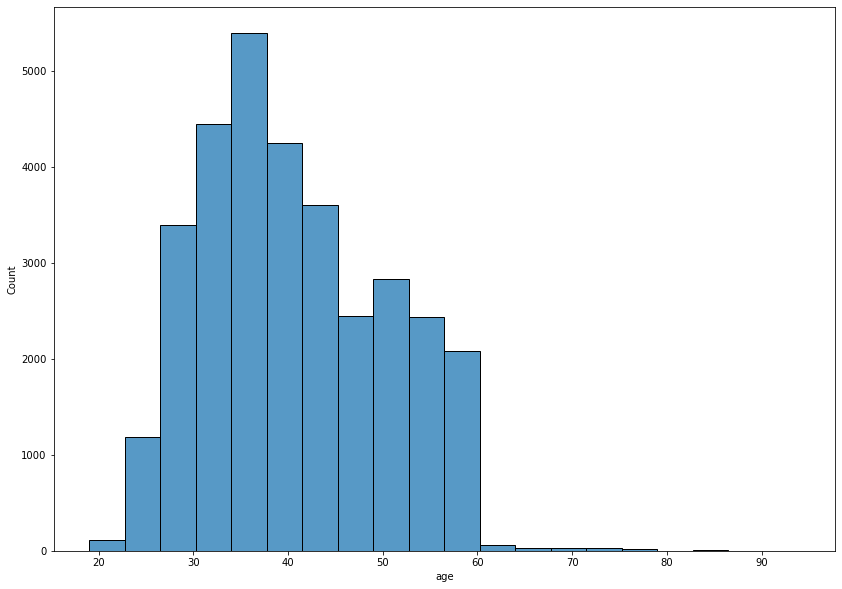

In [108]:
#sns.histplot(data=x_train, x='balance')
sns.histplot(data=x_train, x='age',bins=20)
plt.show()

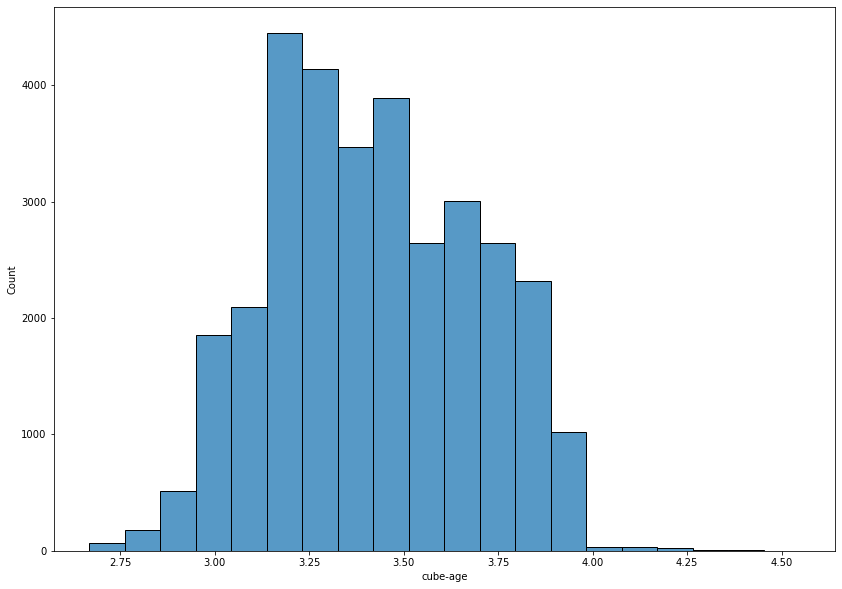

In [109]:
#sns.histplot(data=x_train, x='balance')
sns.histplot(data=x_train, x='cube-age',bins=20)
plt.show()

In [116]:
## Look at Random Forest feature importance
clf = RandomForestClassifier(random_state=30)
clf = clf.fit(x_train, np.ravel(y_train))

importances = pd.Series(clf.feature_importances_, index=x_train.columns)
print ('Mean decrease in impurity importances:')
print (importances.sort_values(ascending=False)[0:50])

Mean decrease in impurity importances:
duration               0.188755
log-duration           0.184181
log-balance            0.053729
balance                0.053723
day                    0.052708
age                    0.030097
sqrt-age               0.029463
cube-age               0.028960
norm-age               0.028636
log-age                0.028511
month_mar              0.013936
housing                0.013252
cube-campaign          0.012607
sqrt-campaign          0.012467
campaign               0.012387
log-campaign           0.012379
norm-campaign          0.012195
month_apr              0.008676
marital_married        0.008576
earlyMonth             0.008436
education_secondary    0.008402
education_tertiary     0.008366
lateMonth              0.008227
contact_cellular       0.008132
job_management         0.007889
job_technician         0.007771
spring                 0.007579
endMonth               0.007508
job_blue-collar        0.007251
month_may              0.007006
b

In [112]:
## Look at Mutual Information metric to assess weak relationships between features and target
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(x_train, np.ravel(y_train))
display (mi_scores[0:50])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, U

duration               0.106777
log-duration           0.106777
log-balance            0.081158
balance                0.081158
age                    0.004687
norm-age               0.004687
sqrt-age               0.004687
log-age                0.004687
cube-age               0.004687
day                    0.004666
contact_unknown        0.004327
month_mar              0.004169
contact_cellular       0.003893
month_apr              0.003174
61+                    0.002303
month_oct              0.001780
log-campaign           0.001753
cube-campaign          0.001753
campaign               0.001753
norm-campaign          0.001753
sqrt-campaign          0.001753
marital_married        0.001679
housing                0.001419
marital_single         0.001401
education_tertiary     0.001020
summer                 0.000908
month_may              0.000684
25-32                  0.000586
job_student            0.000564
month_feb              0.000551
spring                 0.000528
job_blue

In [115]:
# Look at the skewness of independent variables
x_train.skew().sort_values(ascending=False)[0:50]

month_dec             54.246911
month_oct             22.795409
61+                   13.267533
job_unknown           12.807479
month_mar             12.040159
balance                8.632075
< 25                   8.569431
<25                    8.569431
job_student            8.476260
default                6.807353
job_housemaid          5.832430
job_unemployed         5.754281
month_jan              5.541956
job_self-employed      5.075614
job_entrepreneur       5.053195
job_retired            4.980277
education_unknown      4.833397
campaign               4.666977
norm-campaign          4.666977
month_feb              3.830178
contact_telephone      3.777514
month_apr              3.437229
duration               3.244179
winter                 2.934932
month_nov              2.851684
fall                   2.811821
job_services           2.703861
job_admin              2.454754
marital_divorced       2.391113
month_jun              2.381796
month_aug              2.209044
sqrt-cam

In [21]:
# Look at the correlations between independent variables
x_train.corr()

,age,default,balance,housing,loan,day,duration,campaign,marital_divorced,marital_married,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
age,1.000000,-0.017392,0.084104,-0.177720,0.001538,-0.010509,-0.036977,0.015357,0.158711,0.267697,...,0.028798,0.080188,-0.008258,0.331944,0.007073,-0.057061,-0.157031,-0.059972,0.007402,0.041581
default,-0.017392,1.000000,-0.070010,-0.021649,0.072353,0.003997,-0.009589,0.010320,0.016021,-0.015003,...,0.023733,0.001670,-0.002366,-0.005481,0.010902,-0.004715,-0.012930,-0.004107,0.006390,-0.005489
balance,0.084104,-0.070010,1.000000,-0.050397,-0.080532,0.009822,0.010241,-0.009422,-0.026336,0.026103,...,0.017067,0.002355,0.069669,0.015724,0.018464,-0.034637,0.000674,-0.014526,0.012085,0.006710
housing,-0.177720,-0.021649,-0.050397,1.000000,0.005567,-0.052076,0.022125,-0.051628,-0.007522,0.002823,...,-0.001121,-0.084432,-0.067183,-0.115154,-0.031937,0.063531,-0.035464,-0.028944,-0.042416,-0.079072
loan,0.001538,0.072353,-0.080532,0.005567,1.000000,0.005057,-0.002799,0.003053,0.015375,0.035383,...,0.039626,-0.015451,-0.038450,0.018517,-0.009217,0.034454,-0.049250,0.007140,-0.039462,-0.031460
day,-0.010509,0.003997,0.009822,-0.052076,0.005057,1.000000,-0.035111,0.163871,-0.003051,0.003769,...,-0.004393,0.003391,0.026376,-0.002485,0.006252,-0.004530,-0.009121,0.031031,-0.011316,-0.011426
duration,-0.036977,-0.009589,0.010241,0.022125,-0.002799,-0.035111,1.000000,-0.088703,0.001344,-0.028053,...,0.004251,-0.004630,-0.012811,0.001814,0.011001,0.005431,-0.003835,-0.007275,0.015776,-0.010645
campaign,0.015357,0.010320,-0.009422,-0.051628,0.003053,0.163871,-0.088703,1.000000,-0.023792,0.029740,...,-0.002571,0.004597,0.024047,-0.015218,0.001354,-0.006790,-0.007117,0.015952,-0.016886,0.015519
marital_divorced,0.158711,0.016021,-0.026336,-0.007522,0.015375,-0.003051,0.001344,-0.023792,1.000000,-0.453601,...,0.001339,0.014214,0.008855,0.033079,-0.015426,0.017490,-0.038907,0.016709,0.007267,-0.010722
marital_married,0.267697,-0.015003,0.026103,0.002823,0.035383,0.003769,-0.028053,0.029740,-0.453601,1.000000,...,0.045047,0.047235,-0.035691,0.060685,0.015362,-0.015466,-0.127764,-0.075515,-0.011295,0.012105


In [26]:
# Generate VIF factors for each feature
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = x_train.columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(x_train.values, i) for i in range(len(x_train.columns))] 
  
display(vif_scores[0:8])

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Attribute,VIF Scores
0,age,1.488918
1,default,1.014574
2,balance,1.054942
3,housing,1.419756
4,loan,1.060553
5,day,1.446492
6,duration,1.017058
7,campaign,1.134165


In [178]:
# Current best: duration:         -6229.677465 12463.354929 12480.126756 0.241636
# Current best: month-mar:        -6032.348877 12070.697755 12095.855496 0.260223
# Current best: contact-cellular: -5910.007840 11828.015679 11861.559334 0.263941
# Current best: month-oct:        -5812.002622 11634.005245 11675.934813 0.289963
# Current best: 61+:              -5734.741814 11481.483628 11531.799110 0.293680
# Current best: marital-single:   -5702.776459 11419.552918 11478.254314 0.301115

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

summaryTab = []
x_train['intercept'] = 1.0
x_valid['intercept'] = 1.0

for col in x_train:
    useCols = ['duration', 'month_mar', 'contact_cellular', 'month_oct', '61+', 'marital_single', 'intercept']
    if (col in useCols):
        continue
    if (col == 'log-duration'):
        continue
    #useCols.append(col)
    logReg = sm.Logit(y_train, x_train[useCols])
    result = logReg.fit(disp=False)
    y_pred = logReg.predict(result.params, exog=x_valid[useCols])
    tmp = pd.DataFrame(np.array([y_valid, y_pred.round()]).T, columns=['valid', 'pred'])
    minoritySuccess = 0.0
    if 1.0 in tmp.value_counts()[1.0].keys():
        minoritySuccess = tmp.value_counts()[1.0][1.0]/tmp.value_counts()[1.0].sum()
    summaryTab.append([col, result.pvalues.max(), result.llf, result.aic, result.bic, minoritySuccess])
    break
    
tab = pd.DataFrame(summaryTab, columns=['name', 'max_pvalue','llf', 'aic', 'bic', 'minoritySuccessRate'])
print('AIC, BIC:', tab.aic.min(), tab.bic.min())
tab.sort_values(by='minoritySuccessRate', ascending=False)[0:50]

AIC, BIC: 11419.552917687182 11478.254313599646


,name,max_pvalue,llf,aic,bic,minoritySuccessRate
0,age,5.633210e-16,-5702.776459,11419.552918,11478.254314,0.301115


In [167]:
# Current best: log-duration: -5917.676564 11839.353127 11856.124955 0.185874
#-5241.800010 10503.600019 10587.459156 0.323420

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

summaryTab = []
x_train['intercept'] = 1.0
x_valid['intercept'] = 1.0

for col in x_train:
    useCols = ['log-duration', 'month_mar', 'contact_cellular', 'month_oct', '61+', '25-32', 'job_student', 'marital_married', 'housing', 'month_apr', 'intercept']
    if (col in useCols):
        continue
    #useCols.append(col)
    logReg = sm.Logit(y_train, x_train[useCols])
    result = logReg.fit(disp=False)
    y_pred = logReg.predict(result.params, exog=x_valid[useCols])
    tmp = pd.DataFrame(np.array([y_valid, y_pred.round()]).T, columns=['valid', 'pred'])
    minoritySuccess = 0.0
    if 1.0 in tmp.value_counts()[1.0].keys():
        minoritySuccess = tmp.value_counts()[1.0][1.0]/tmp.value_counts()[1.0].sum()
    summaryTab.append([col, result.pvalues.max(), result.llf, result.aic, result.bic, minoritySuccess])
    break
    
tab = pd.DataFrame(summaryTab, columns=['name', 'max_pvalue','llf', 'aic', 'bic', 'minoritySuccessRate'])
print('AIC, BIC:', tab.aic.min(), tab.bic.min())
tab.sort_values(by='minoritySuccessRate', ascending=False)[:50]

AIC, BIC: 10481.498095522707 10573.743146242292


,name,max_pvalue,llf,aic,bic,minoritySuccessRate
0,age,0.00485,-5229.749048,10481.498096,10573.743146,0.330855


In [241]:
sm.qqplot(result.resid_working, line='45')
#plt.ylim([-9,9])
plt.show()

AttributeError: 'LogitResults' object has no attribute 'resid_working'

(0.0, 2500.0)

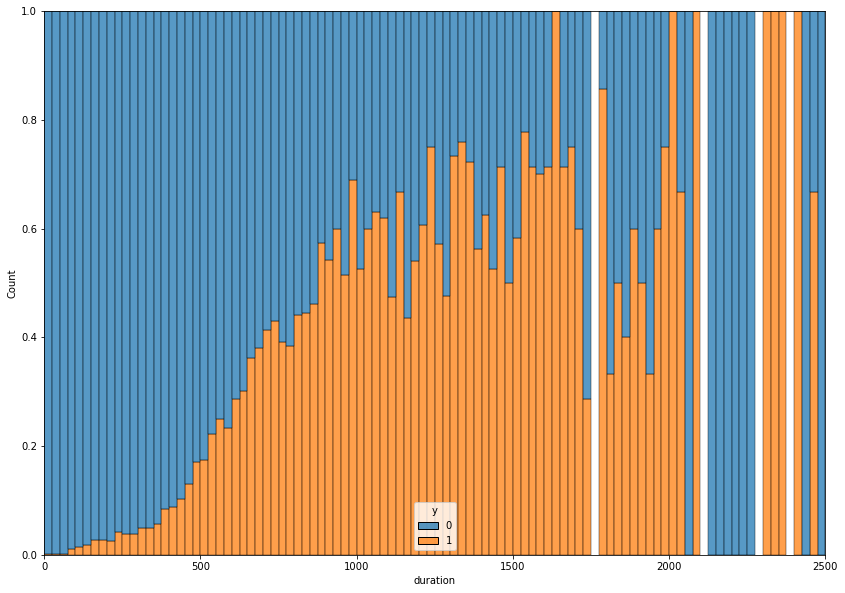

In [356]:
sns.histplot(data=x_train, x='duration', hue=y_train, binwidth=25, multiple='fill')
plt.xlim([0,2500])

<AxesSubplot:>

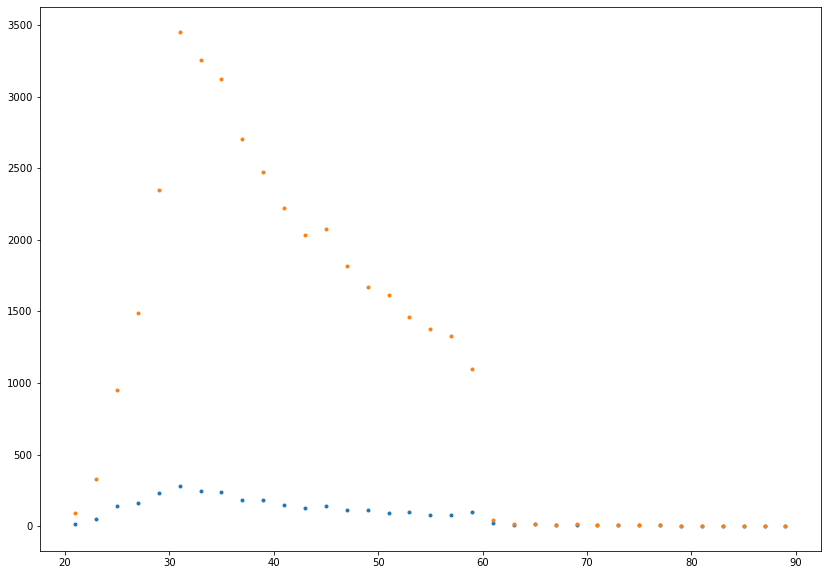

In [500]:
#### YES ####
series = rawData.loc[rawData.y == 'yes']['age']
startValue = 20
binSize = 2
numBins = 35
largeValue = 100000

binDFyes = pd.cut(series, bins=[startValue + binSize*i for i in range(0,numBins)] + [largeValue], 
                     labels=[startValue + binSize*i+binSize/2.0 for i in range(0,numBins)]).value_counts()

binDFyes.index = binDFyes.index.astype(float)

#### NO ####
series = rawData.loc[rawData.y == 'no']['age']
startValue = 20
binSize = 2
numBins = 35
largeValue = 100000

binDFno = pd.cut(series, bins=[startValue + binSize*i for i in range(0,numBins)] + [largeValue], 
                     labels=[startValue + binSize*i+binSize/2.0 for i in range(0,numBins)]).value_counts()

binDFno.index = binDFno.index.astype(float)





binDFyes.plot(x=float(index), y='age', style='.')
binDFno.plot(x=float(index), y='age', style='.')

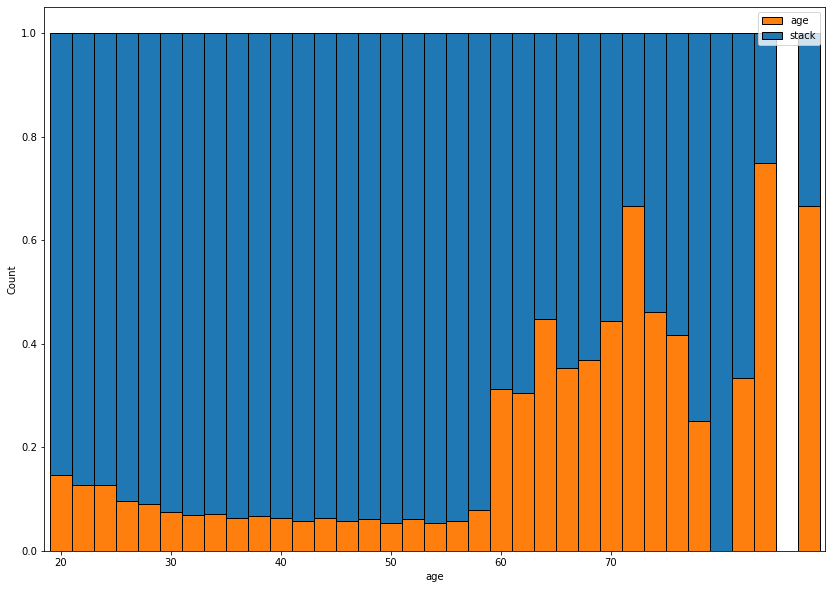

In [501]:
combine = binDFyes/(binDFyes+binDFno)
combineDF = combine.to_frame()
combineDF['stack'] = 1.0 - combineDF['age']
ax = combineDF.plot(kind='bar', use_index=True, y=['age','stack'], color=[sns.color_palette()[1], sns.color_palette()[0]], edgecolor='k', linewidth=1, stacked=True, width=1.00)
ax.set_ylabel('Count')
ax.set_xlabel('age')
ax.set_xticks([0,5,10,15,20,25])
ax.set_xticklabels(['20','30','40','50','60','70'], rotation=0)
plt.show()

(0.0, 91.0)

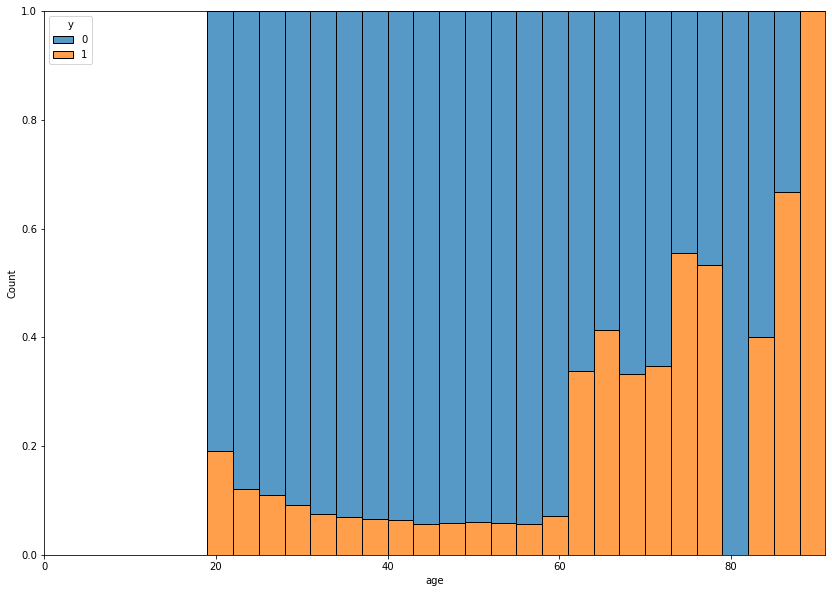

In [493]:
sns.histplot(data=x_train, x='age', hue=y_train, binwidth=3, multiple='fill')
plt.xlim([0,91])

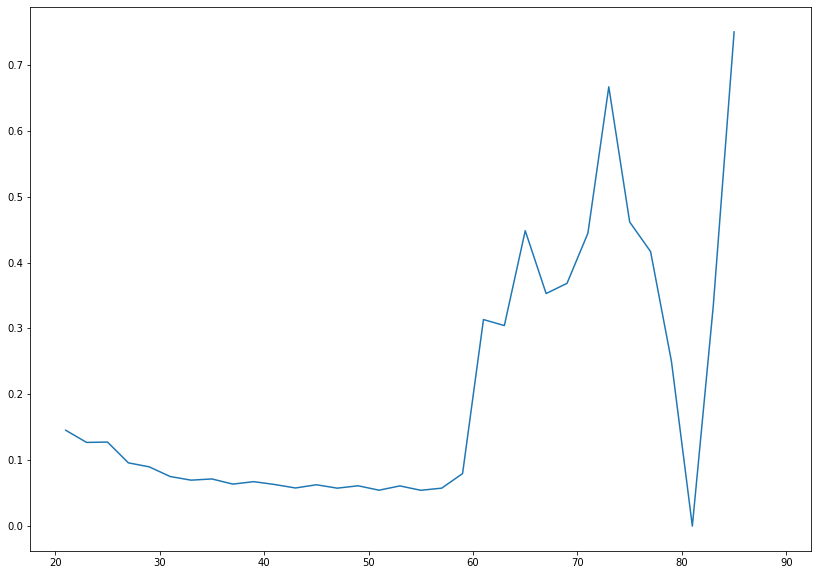

In [503]:
plt.plot(combineDF['age'])

In [246]:
#x_test['intercept'] = 1.0
y_predTest = logReg.predict(resultSkew.params, exog=x_test[useCols])

In [247]:
tmp = pd.DataFrame(np.array([y_test, y_predTest.round()]).T, columns=['valid', 'pred'])

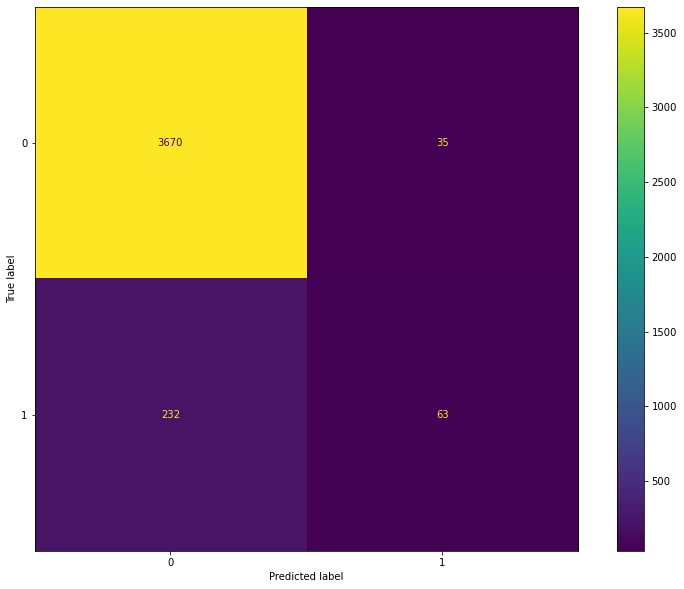

In [248]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predTest.round())
ConfusionMatrixDisplay(cm).plot()

In [249]:
accuracy_score(y_test, y_predTest.round())

0.93325

In [252]:
balanced_accuracy_score(y_test, y_predTest.round())

0.6020563141883392

In [255]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

summaryTab = []
x_train['intercept'] = 1.0
x_valid['intercept'] = 1.0

for col in x_train:
    useCols = ['duration', 'month_oct', 'month_mar', 'month_jun', 'month_jan', 'day', 'job_admin', 'job_housemaid', 'contact_cellular', 'marital_divorced', 'job_student', 'intercept']
    if (col in useCols):
        continue
    #useCols.append(col)
    logReg = sm.Logit(y_train, x_train[useCols])
    result = logReg.fit(disp=False)
    y_pred = logReg.predict(result.params, exog=x_valid[useCols])
    tmp = pd.DataFrame(np.array([y_valid, y_pred.round()]).T, columns=['valid', 'pred'])
    minoritySuccess = 0.0
    if 1.0 in tmp.value_counts()[1.0].keys():
        minoritySuccess = tmp.value_counts()[1.0][1.0]/tmp.value_counts()[1.0].sum()
    summaryTab.append([col, result.pvalues.max(), result.llf, minoritySuccess])
    break
    
tab = pd.DataFrame(summaryTab, columns=['name', 'max_pvalue', 'llf', 'minoritySuccessRate'])
tab.sort_values(by='minoritySuccessRate', ascending=False)

,name,max_pvalue,llf,minoritySuccessRate
0,age,0.026081,-5712.507756,0.32342


In [256]:
resultNoSkew = result
resultNoSkew.pvalues

duration            0.000000e+00
month_oct           8.965920e-62
month_mar           1.237259e-97
month_jun           6.199759e-19
month_jan           1.711584e-12
day                 1.146706e-04
job_admin           2.608113e-02
job_housemaid       4.577176e-05
contact_cellular    3.934176e-70
marital_divorced    1.012386e-02
job_student         1.007805e-10
intercept           0.000000e+00
dtype: float64

In [257]:
resultNoSkew.params

duration            0.004664
month_oct           4.799100
month_mar           3.163325
month_jun           0.934181
month_jan          -1.644131
day                 0.012965
job_admin           0.175932
job_housemaid      -0.840282
contact_cellular    1.346144
marital_divorced    0.197275
job_student         1.064678
intercept          -5.702819
dtype: float64

In [258]:
x_test['intercept'] = 1.0
y_predTest = logReg.predict(resultNoSkew.params, exog=x_test[useCols])

In [259]:
tmp = pd.DataFrame(np.array([y_test, y_predTest.round()]).T, columns=['valid', 'pred'])

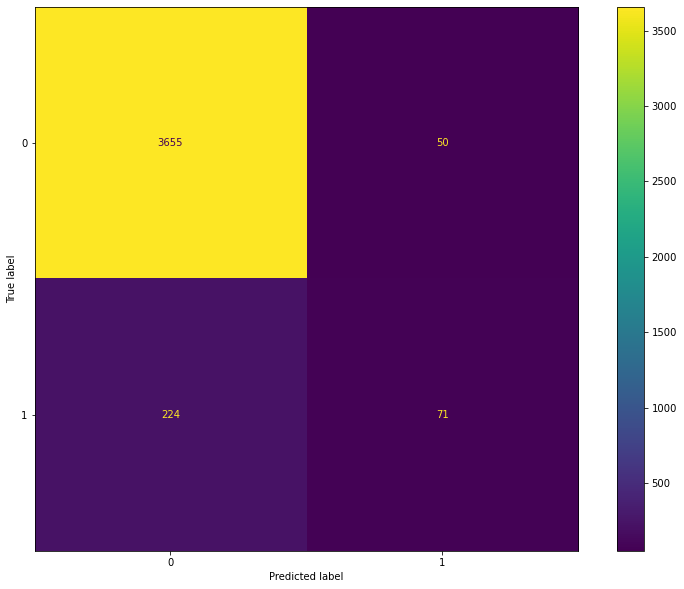

In [260]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predTest.round())
ConfusionMatrixDisplay(cm).plot()

In [261]:
accuracy_score(y_test, y_predTest.round())

0.9315

In [262]:
balanced_accuracy_score(y_test, y_predTest.round())

0.6135913447242618

In [600]:
binned

,pctYes,total
ageBins,,
<20,0.166667,12
20,0.181818,22
21,0.179487,39
22,0.126761,71
23,0.114094,149
...,...,...
85,1.000000,3
86,0.000000,1
87,NaN,0


In [622]:
labels

['<20',
 '20.5',
 '23.5',
 '26.5',
 '29.5',
 '32.5',
 '35.5',
 '38.5',
 '41.5',
 '44.5',
 '47.5',
 '50.5',
 '53.5',
 '56.5',
 '59.5',
 '62.5',
 '65.5',
 '68.5',
 '>71']

<AxesSubplot:xlabel='ageBins'>

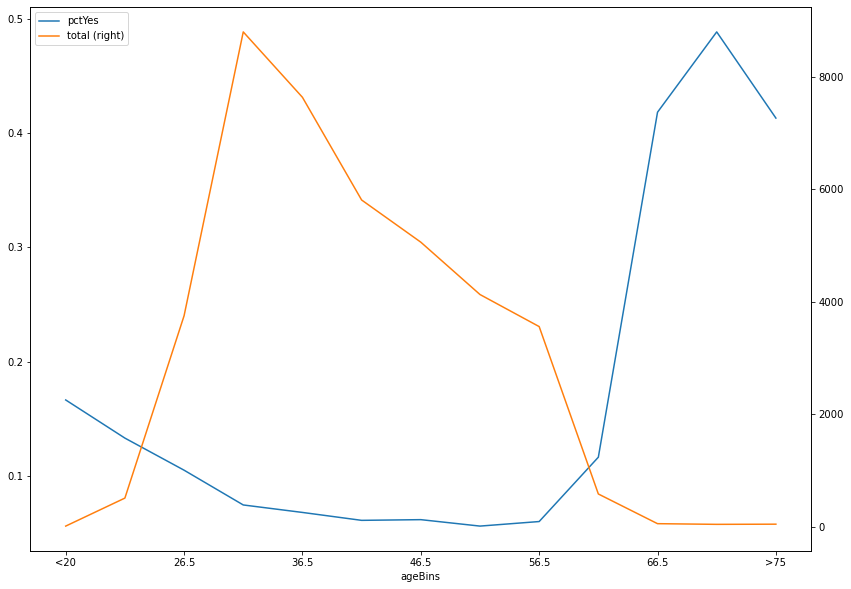

In [718]:
smallNumber = 0
largeNumber = 1000
startValue = 20
binSize = 5
shift = binSize/2.0
numBins = 12
var = 'age'

#smallNumber = -100
#largeNumber = 1000
#startValue = 0
#binSize = 25
#shift = binSize/2.0
#numBins = 100
#var = 'duration'

#smallNumber = -10000
#largeNumber = 10000000
#startValue = -1000
#binSize = 500
#shift = binSize/2.0
#numBins = 100
#var = 'balance'

bins = [smallNumber] + [startValue-1 + binSize*i for i in range(0,numBins)] + [largeNumber]
labels = ['<' + str(startValue)] + [str(startValue-1 + binSize*i + shift) for i in range(0,numBins-1)] + ['>' + str(startValue+(numBins-1)*binSize)]

newPlay[var + 'Bins'] = pd.cut(newPlay[var], bins=bins, labels=labels)
grouped = newPlay.groupby(by=['y',var + 'Bins']).count()[[var]]
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
binned.plot(y=['pctYes','total'], secondary_y=['total'])

<AxesSubplot:xlabel='job'>

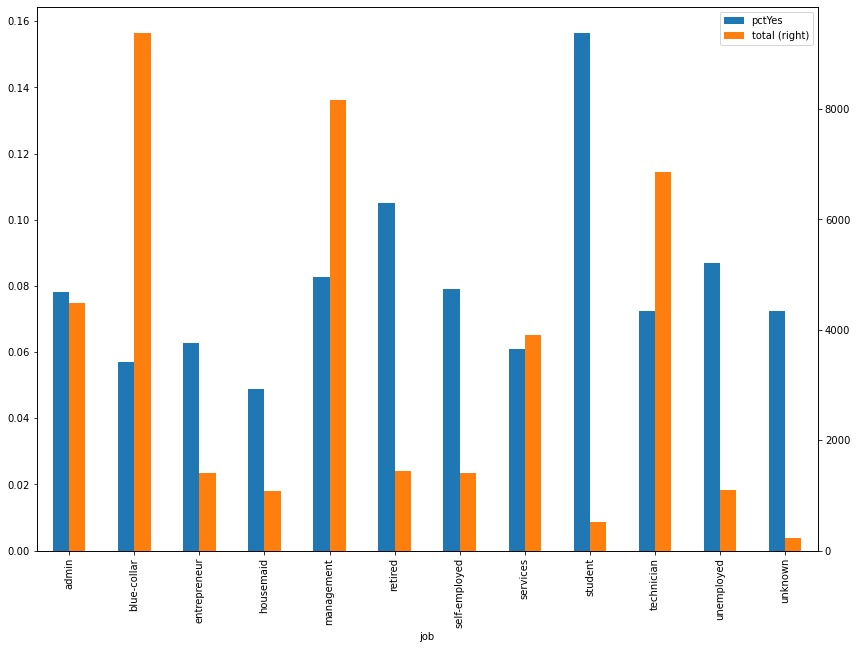

In [641]:
var = 'job'

grouped = newPlay.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
binned.plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])

<AxesSubplot:xlabel='marital'>

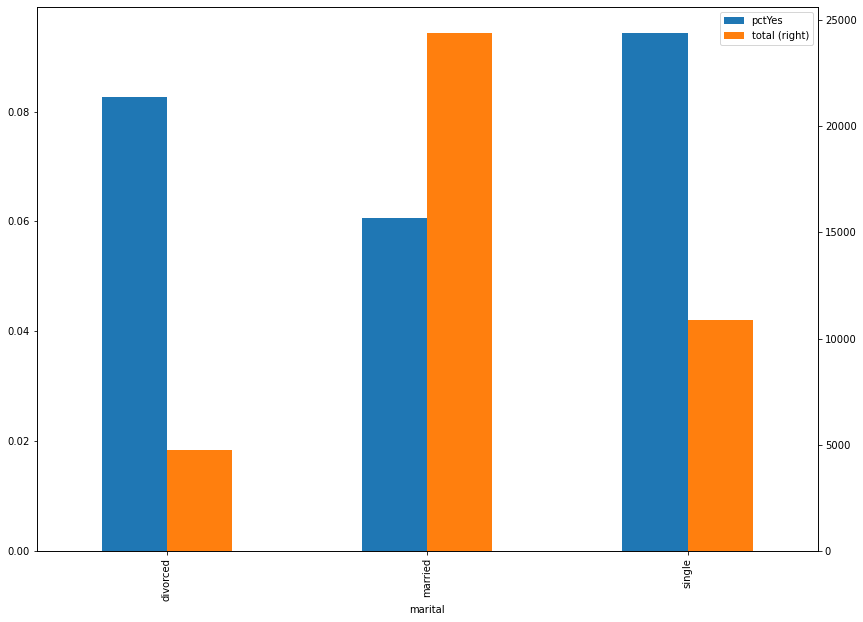

In [642]:
var = 'marital'

grouped = newPlay.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
binned.plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])

<AxesSubplot:xlabel='contact'>

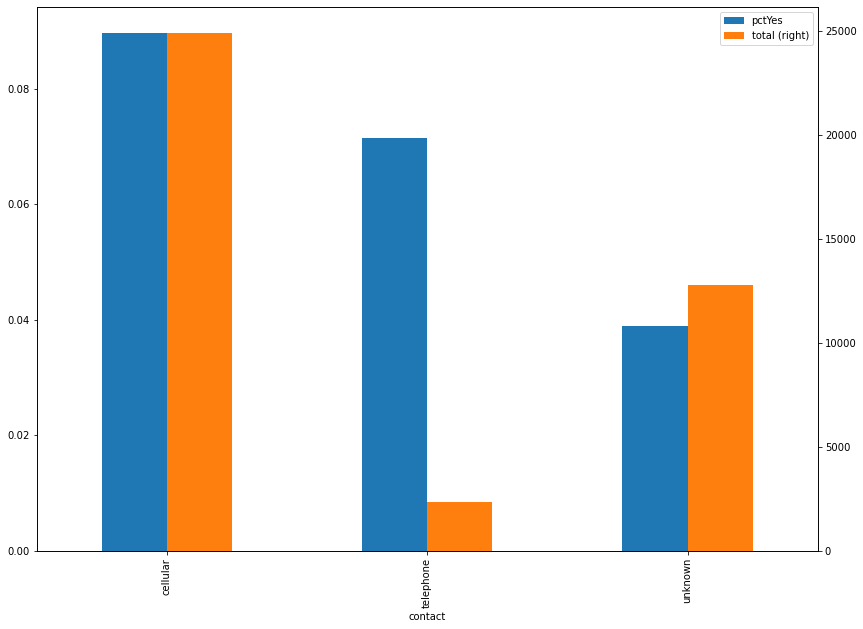

In [645]:
var = 'contact'

grouped = newPlay.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
binned.plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])

<AxesSubplot:xlabel='month'>

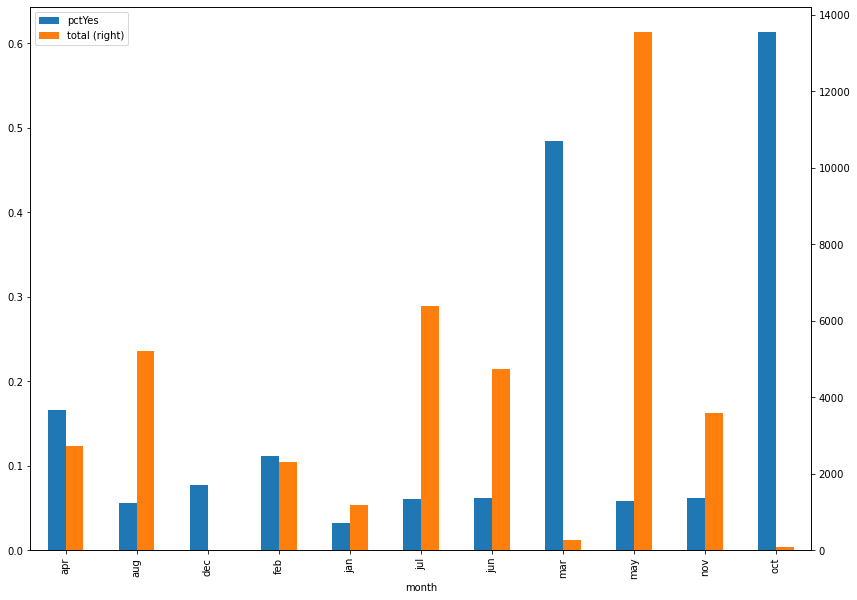

In [646]:
var = 'month'

grouped = newPlay.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
binned.plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])

<AxesSubplot:xlabel='day'>

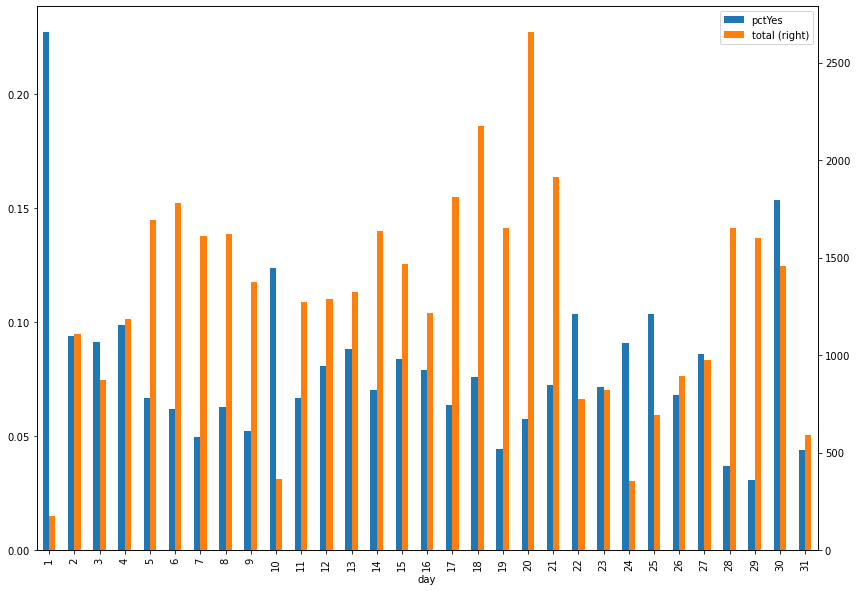

In [647]:
var = 'day'

grouped = newPlay.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
binned.plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])

<AxesSubplot:xlabel='education'>

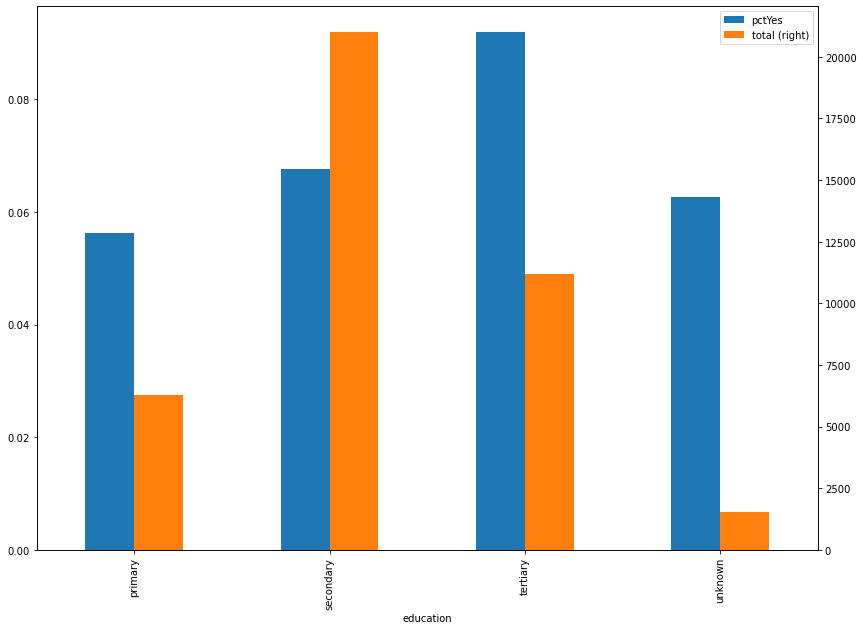

In [693]:
var = 'education'

grouped = newPlay.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
binned.plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])

In [740]:
var = 'ageBins'

grouped = newPlay.groupby(by=['y',var,'marital']).count()['default']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
#binned.plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])

In [746]:
binned.loc[(binned.pctYes > 0.11) & (binned.total > 10)]

pctYes  total
ageBins marital                  
<20     single    0.166667     12
21.5    single    0.143198    419
26.5    divorced  0.115789     95
        single    0.123669   2442
61.5    divorced  0.147059    102
        married   0.112335    454
66.5    married   0.400000     45
71.5    married   0.486486     37
>75     divorced  0.600000     15
        married   0.333333     30

In [744]:
binned.loc[(binned.pctYes < 0.06) & (binned.total > 15)]

pctYes  total
ageBins marital                 
36.5    married  0.059465   4675
41.5    married  0.053106   3992
46.5    married  0.057465   3724
51.5    married  0.051859   3066
56.5    married  0.057004   2684
        single   0.056995    193

In [617]:
## AIC/BIC scores --> setup a baseline with something bare minumim
### Want them to come down

## Normalize outliers
## Cap outliers
## Bin outliers
## Remove outliers -> row/column -- imputed


In [719]:
newPlay

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,ageBins,durationBins,balanceBins
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no,56.5,254.0,2249.0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no,41.5,164.0,249.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no,31.5,74.0,249.0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no,46.5,104.0,1749.0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no,31.5,194.0,249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no,51.5,104.0,249.0
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes,31.5,224.0,3249.0
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes,51.5,164.0,249.0
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no,31.5,344.0,1249.0


In [669]:
no.sum()

37104

In [691]:
import scipy.stats as stats
indxLow = 10
indxHigh = 18

obs = yes.iloc[indxLow:indxHigh].values
exp = (yes.iloc[indxLow:indxHigh]+no.iloc[indxLow:indxHigh]).values * (yes.iloc[indxLow:indxHigh].sum()/(yes.iloc[indxLow:indxHigh].sum() + no.iloc[indxLow:indxHigh].sum()))

stats.chisquare(f_obs=obs, f_exp=exp)

Power_divergenceResult(statistic=10.209154699825637, pvalue=0.17702745986967186)